In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))
display(HTML(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """))

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter
    <a href=\"https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/\">extensions</a>.
</div>

# SIR parameter learning using LM-BFGS for exact target

$\newcommand{\R}{\,\mathbb{R}} \newcommand{\dif}{\mathrm{d}} \newcommand{\diag}{\mathrm{diag}} \newcommand{\vec}{\mathrm{vec}}  \newcommand{\circulant}{\mathrm{circ}} \newcommand{\mat}{\mathrm{mat}} \newcommand{\ifft}{\hat{\mathcal{F}}} \newcommand{\fft}{\mathcal{F}}$
<div class="alert alert-block alert-success">
This notebook aims to solve the minimisation problem
\begin{align}
    \min_{\alpha \in [0,1]^2} f(\alpha) = \frac{1}{2} \| \rho - \widehat{\rho} \|_2^2,
\end{align}
where $\rho = (\begin{smallmatrix} S & I & R \end{smallmatrix})$ comes from the solution of the traditional forward Susceptibles, Infected, and Recovered (SIR) model, and $\widehat{\rho}$ is a target and known state.
    
For each pair of parameters $\alpha = (\beta, \gamma) \in [0,1]^2$ corresponding to the transmission and the recovery rates, the three variables $S(t)$, $I(t)$, and $R(t)$ are governed by the following differential equations
    
\begin{align}
    \frac{\dif S}{\dif t} &= -\beta S I,
    \\
    \frac{\dif I}{\dif t} &= \beta S I - \gamma I,
    \\
    \frac{\dif R}{\dif t} &= \gamma I.
\end{align}
    
We note that $S + I + R = n$, where $n$ is the total population. 
    
</div>

In [1]:
# Packages
import time
import numpy  as np
import pandas as pd
import gurobipy as GRB
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from scipy.integrate import solve_ivp

In [3]:
# Single function imports
from numpy           import array, asarray, sin, cos, zeros, linspace, argmin, meshgrid, unravel_index
from numpy           import concatenate, minimum, maximum, exp, ones, eye, empty, append, diagflat, tril, triu
from numpy           import logical_and, where, allclose, full, clip
from numpy.random    import default_rng as rng
from scipy.linalg    import norm, eigvals, inv
from scipy.integrate import simpson
from scipy.optimize  import minimize, Bounds
from scipy.interpolate   import CubicHermiteSpline
from scipy.sparse.linalg import LinearOperator
from scipy.sparse    import eye as speye
from scipy.sparse    import bmat
from numpy.polynomial.chebyshev import chebpts1

Initial conditions:

In [4]:
# Total population
n = 200
# Initial conditions
f = 5e-3
Sₒ, Iₒ, Rₒ = (1-f)*n, f*n, 0.0
# Rates
α = β, γ = 0.03, 0.6
m = 0

In [5]:
ℛ_ₒ = (β * n)/(γ + m)
print(ℛ_ₒ)

10.0


## Generation of $\widehat \rho$

We are going to generate one choice for $\widehat\rho$. The first, labelled $\widehat\rho_{\mathsf e}$ is just three curves that satisfy the initial conditions.

In [6]:
T  = 10                            # Final time
Tₑ = 0.5*(chebpts1(200)+1) * T     # Evaluation interval using Chebyshev points of the first kind
Tₑ = concatenate([[0],Tₑ,[T]])     # Add endpoints

In [7]:
def SIR(t, z, β,γ):
    S, I, R = z
    return [-β*S*I, β*S*I - γ*I - m*I, γ*I]

In [8]:
# Compute state ρ(α)
ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                  dense_output=True, vectorized=True)
if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
ρ = ρ_sol.y
ρ̂ = ρ.copy()

# Create an abstract interpolator for state
ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
ρ̄ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)

In [9]:
ρ̄ₙ = ρ̄
ρ̄ₑ = ρ̄

ρ̂ₙ = ρ̂
ρ̂ₑ = ρ̂

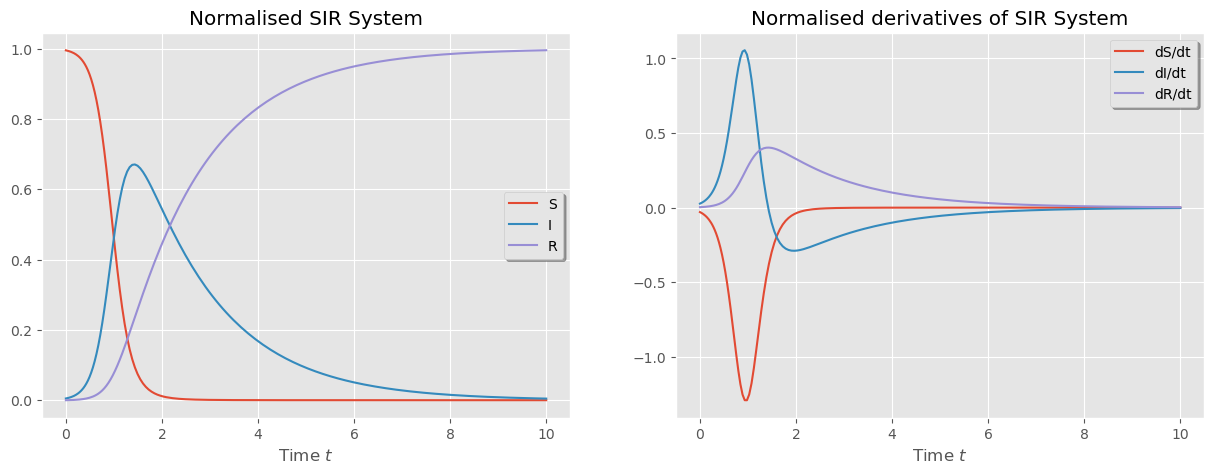

In [10]:
# Plot SIR curves
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, α[0], α[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

## Adjoint system

The adjoint state can be found by solving the following ODE system:

\begin{align}
    \frac{\dif q_S}{\dif t} &= \hat{S} - S +\beta I(q_S - q_I),
    \\
    \frac{\dif q_I}{\dif t} &= \hat{I} - I + \beta S(q_S - q_I) + \gamma (q_I - q_R) + m q_I,
    \\
    \frac{\dif q_R}{\dif t} &= \hat{R} - R,
\end{align}
with the terminal condition $q(T) = 0$.

Let us see how we can implement this with an adaptive step method:

In [11]:
def Adjoint(t, z, β,γ,ρ):
    S̄, Ī, R̄ = ρ̄ₑ(t)    # Target
    S, I, R = ρ(t)     # State
    qₛ, qᵢ, qᵣ = z     # Adjoint
    return [S̄ - S + β*I*(qₛ - qᵢ), Ī - I + β*S*(qₛ - qᵢ) + γ*(qᵢ - qᵣ) + m*qᵢ, R̄ - R]

Let us try solving this problem for $\rho = \widehat{\rho}_{\mathsf n}$:

In [12]:
solₛ = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(0.1, 0.01,ρ̄ₙ), t_eval = Tₑ[::-1], dense_output=True, vectorized=False)
print(solₛ['message'],'There were',solₛ.nfev,'function evaluations.')

The solver successfully reached the end of the integration interval. There were 50 function evaluations.


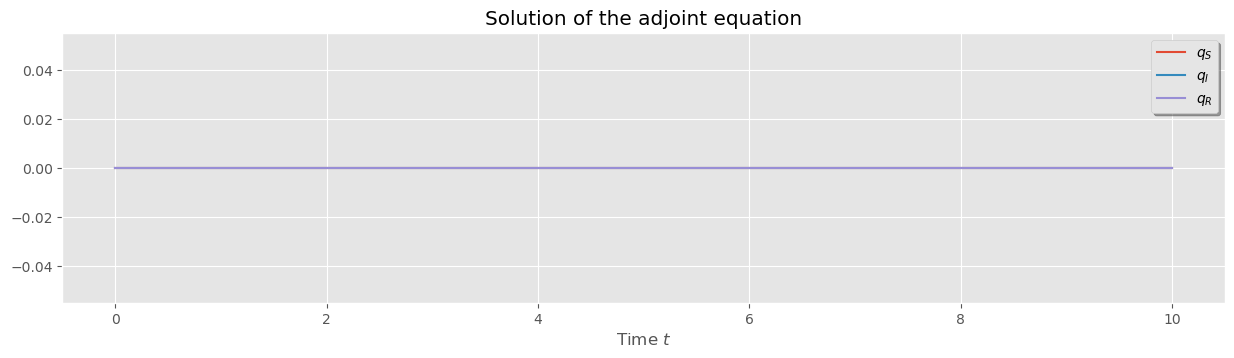

In [13]:
# Plot adjoint curves
plt.figure(figsize=(15,3.5))
plt.plot(Tₑ[::-1],solₛ.y.T)
plt.xlabel(r'Time $t$')
plt.legend([r'$q_S$', '$q_I$', '$q_R$'], shadow=True)
plt.title('Solution of the adjoint equation')
plt.show()

Now we try to optimise the function
\begin{align}
    f(\alpha) = \frac{1}{2} \int\limits_0^T \big( S(t) - \hat{S}(t) \big)^2 + \big( I(t) - \hat{I}(t) \big)^2 + \big( R(t) - \hat{R}(t) \big)^2 \,\dif t.
\end{align}

In [14]:
def Objective(ρ,ρ̂):    return 0.5 * simpson((ρ-ρ̂)**2,x=Tₑ).sum()

In [15]:
def proj(α):    return minimum(maximum(α,0.0),1.0)

In [16]:
print('As an example, the distance between ρ̂ and ρ̂ₑ is {0:.4f}.'.format( Objective(ρ̂,ρ̂ₑ) ))

As an example, the distance between ρ̂ and ρ̂ₑ is 0.0000.


Now we can compute the derivative of the reduced objective functional [ ! ]:
\begin{align}
    \frac{\partial f}{\partial \beta} &= \int\limits_0^T S I( q_I - q_S ) \, \dif t
    \\
    \frac{\partial f}{\partial \gamma} &= \int\limits_0^T I( q_R - q_I ) \, \dif t
\end{align}

In [17]:
q = solₛ.y[:,::-1]

In [18]:
df = asarray([simpson(ρ̂ₙ[0]*ρ̂ₙ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ̂ₙ[1] * (q[2]-q[1]), x=Tₑ)])
display(df.tolist())

[0.0, 0.0]

# Surfaces

For computational practicity, we will store the computed state and adjoint variables during the evaluation of the objective and derivatives.

In [19]:
global ρ, q
ρ, q = empty((3, Tₑ.size), np.float64), empty((3, Tₑ.size), np.float64)

In [20]:
def obj_eval(α):                  # ** Eval f and f' ** #
    global ρ, q, df
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ, asarray(SIR(0,ρ,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=False)
    q = q_sol.y[:,::-1]

    # Compute derivative
    df = asarray([simpson(ρ[0]*ρ[1] * (q[1]-q[0]), x=Tₑ), simpson(ρ[1] * (q[2]-q[1]), x=Tₑ)])
    df /= (n**2) if scaling else 1.0
    
    return asarray(f), df
def obj_eval_a(α):                # ** Eval just f ** #
    global ρ
    '''
        Evaluate state and return objective
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ = ρ_sol.y
    f = Objective(ρ,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0
    
    return asarray(f)
def obj_eval_b(α):                # ** Does not affect global variable ρ ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ̂ = ρ_sol.y
    f = Objective(ρ̂,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0

    return f
def obj_eval_d(α):                # ** Does not affect global variables ρ, q, df ** #
    '''
        Evaluate state, compute adjoint, and return objective and derivative
    '''
    scaling = True
    
    # Compute state α
    ρ_sol = solve_ivp(SIR, [0, T], [Sₒ, Iₒ, Rₒ], args=α, t_eval = Tₑ, 
                      dense_output=True, vectorized=True)
    if ρ_sol['success'] != True:    print('Should re-evaluate for', ω)
    ρ̂ = ρ_sol.y
    f = Objective(ρ̂,ρ̂ₑ)
    f /= (n**2) if scaling else 1.0
    
    # Create an abstract interpolator for state
    ρₜ = CubicHermiteSpline(Tₑ, ρ̂, asarray(SIR(0,ρ̂,α[0],α[1])), axis=-1)
    
    # Compute adjoint
    q_sol = solve_ivp(Adjoint, [T,0], [0.0, 0.0, 0.0], args=(α[0], α[1], ρₜ), t_eval = Tₑ[::-1], 
                      dense_output=True, vectorized=False)
    q̂ = q_sol.y[:,::-1]

    # Compute derivative
    dF = asarray([simpson(ρ̂[0]*ρ̂[1] * (q̂[1]-q̂[0]), x=Tₑ), simpson(ρ̂[1] * (q̂[2]-q̂[1]), x=Tₑ)])
    dF /= (n**2) if scaling else 1.0

    return f, dF

---

In [21]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.007,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

In [22]:
print('Smallest objective found in the mesh: {0};'.format(M_0),'(β,γ):',β_axis[i_0[0]],γ_axis[i_0[1]])

Smallest objective found in the mesh: 0.013002638753914707; (β,γ): 0.02686 0.6276


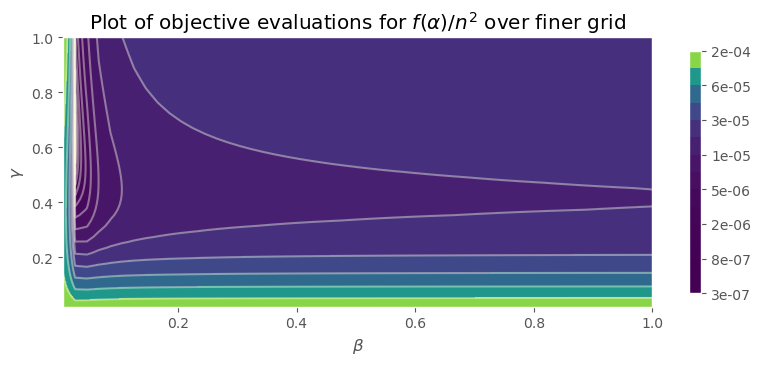

In [23]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(9.5, 3.5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

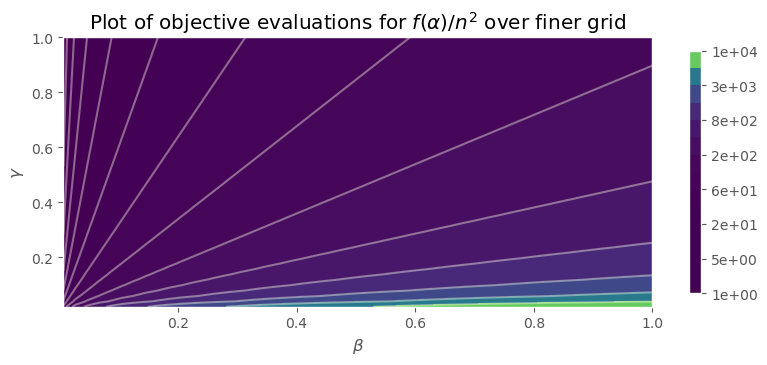

In [24]:
# Contour plot basic reproduction number
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = np.logspace( np.log( Reprod.min() ), np.log( Reprod.max() ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(9.5, 3.5))
cp = ax.contourf(X_c, Y_c, Reprod, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

# Solving the optimisation problem

## Optimisation routine

We will use a trust region limited memory algorithm for optimising $j$. In this setting, we will write $x_k$ for the iterates $\alpha_k$.

To control the success of a direction, which is a linear combination of a proximal direction and the previous step, we define the _predicted reduction_ of $f$ as
\begin{align*}
    \mathrm{pred}_k = j(x_k) - q_k(d_k) = -[\nabla f(x_k)]^\top d_k - \frac{1}{2} \langle d_k, B_k d_k \rangle.
\end{align*}
Here we have omited the evaluation of $\imath_{\mathcal{A}}$ at $x_k$ and $x_k + d_k$ (due to the definition of $d_k$). The _actual reduction_ is defined by $\mathrm{ared}_k = j(x_k) - j(x_k + d_k)$.

The first order residual is defined as $r(x) = \mathrm{prox}_{ \imath_\mathcal{A} }\big(x - \nabla f(x) \big) - x$. 

<div class="alert alert-block alert-warning">
Christian Kanzow & Theresa Lechner. Efficient Regularized Proximal Quasi-Newton Methods for Large-Scale Nonconvex Composite Optimization Problems. Pacific Journal of Optimization (to appear). https://arxiv.org/abs/2210.07644
</div>

<div style="background-color:rgba(0, 0, 0, 0.0470588); vertical-align: middle; padding:5px 0; padding-left: 40px;">
<h2 style="color: #5e9ca0;">Regularised Proximal Quasi–Newton Method</h2>
<ol>
<li>Choose \(x_0 \in \mathrm{dom}(j)\) and a symmetric positive definite matrix \(H_0\). 
    Let parameters satisfy \( \mu_0 > 0 \), \( p_{\min} \in (0, 1/2) \), \(\tau_1 \in (0, 1/2) \), \( \tau_2 \in (\tau_1, 1) \), \( \sigma_1 \in (0, 1) \), \( \sigma_2 > 1 \).
    Now set \(m \in \mathbb{N}\), \(k = 0\), and \(B_0 =H_0^{-1}\).
    </li>
    
<p><bf> \(\mathbf{Repeat}\)</bf></p>
    
<ol>
<li>
    Choose \( B_k \in \mathcal{M}_n (\mathbb{R}) \) and find a direction $d_k$ given by
    \[
        d_k = \mathrm{prox}_{ \imath_{\mathcal{A}} }^{ B_k + \mu_k \mathsf{I} } \big( x_k - (B_k + \mu_k \mathsf{I})^{-1} \nabla j(x_k) \big) - x_k
    \]
</li>
<li> \(\mathbf{If}\) \( \mathrm{pred}_k \leq p_{\min} \|d_k\| \| r(x_k) \| \) \(\mathbf{then}\)
</li>
<ol>
    <li> Set \( \mu_{k} := \sigma_2 \mu_k\), </li>
    <li> Return to step A. </li>
</ol>
<li> \(\mathbf{else}\) </li>
<ol>    
    <li> Go to step D.</li>
</ol>
    
<li> Set \( \rho_k = \mathrm{ared}_k / \mathrm{pred}_k = \dfrac{ f(x_k + d_{k}) - f(x_k)}{ \nabla f(x_k)^\top d_{k} + \frac{1}{2} \, d_{k} ^\top B_k d_{k} } \) and perform the following updates:
    \[
        x_{k+1} = \begin{cases} x_k & \text{if } \rho_k \leq c_1, \\ x_{k} + d_k & \text{otherwise}; \end{cases}
        \qquad
        \mu_{k+1} = 
        \begin{cases}
            \sigma_2 \mu_k & \text{if } \rho_k \leq \tau_1,
            \\
            \mu_k          & \text{if } \tau_1 < \rho_k \leq \tau_2,
            \\
            \sigma_1 \mu_k & \text{if } \rho_k \geq \tau_2.
        \end{cases}
    \]
<ol>
    <li> Let \(\widehat{m} := \min\{k+1,m\}\). </li>
    <li> Update \(B_k\) with the \(n \times \widehat m\) matrices \(S_k\) and \(Y_k\) to get \(B_{k+1} \). </li>
</ol>
</li>
    
<li> Update \( k \leftarrow k+1\) and go to step A.
</li>
    

    

</ol>
    
<p><bf> \(\mathbf{until}\, x_{k}\) satisfies some stopping criteria.</bf></p>
</div>

<div class="alert alert-block alert-warning">
<b>Limited memory</b>
</div>

The limited memory BFGS method approximates the inverse of the Hessian of a functional $j$ at iteration $k+1$, say $H_{k+1}$, without storing the dense matrices $H_k$ at each iteration. Instead, it stores $m$ correction pairs $ \{q_i, d_i\}_{i\in [k-1: k-m]} \subset\mathbb{R}^{n,2} $, where
\begin{equation}
    q_i := x_{i+1} - x_{i}
    \qquad\text{and}\qquad
    d_i := \nabla f(x_{i+1}) - \nabla f(x_{i}),
\end{equation}
that contain information related to the curvature of $f$. Byrd et al (1994) introduced a compact form to define the limited memory matrix $ B_k = H_k^{-1} $ in terms of the $ n\times m $ correction matrices
\begin{equation}
    S_k :=
        \begin{pmatrix}
            q_{k-m} & \cdots & q_{k-1}
        \end{pmatrix}
    \qquad\text{and}\qquad
    Y_k :=
        \begin{pmatrix}
            d_{k-m} & \cdots & d_{k-1}
        \end{pmatrix}.
\end{equation}
%
The main idea of the algorithm is that the matrix $S_k^\top Y_k$ can be written as the sum of the following three matrices:
\begin{equation}
    S_k^\top Y_k = L_k + D_k + R_k,
\end{equation}
where $L_k$ is strictly lower triangular, $D_k$ is diagonal, and $R_k$ is strictly upper triangular.

For $\theta > 0$, if the correction pairs satisfy $ q_i^\top d_i > 0 $, then the matrix obtained by updating $\theta I_n$ with the BFGS formula and the correction pairs after $k$-times can be written as
\begin{align}
    B_k &:= \theta I_n - W_k M_k W_k^\top,
\end{align}
where $W_k$ and $M_k$ are the block matrices given by
\begin{align}
W_k &:= \begin{pmatrix}	Y_k & \theta S_k \end{pmatrix},
\\
M_k &:= \begin{pmatrix}	-D_k & L_k^\top \\  L_k &  \theta S_k^\top S_k	\end{pmatrix}^{-1}.	\label{lbfgs-Bc}
\end{align}
Note that, as $M_k$ is a $2m\times 2m$ matrix, the cost of computing the inverse in the last formula is negligible. Hence, using the compact representation for $B_k$, various computations involving this matrix become inexpensive, as is the case of the product of $B_k$ times a vector.

We skip an update of the method whenever $\langle s_k,y_k\rangle \leq \varepsilon_{\text{LM}} \|s_k\|^2 $.

<div class="alert alert-block alert-warning">
Richard H. Byrd, Jorge Nocedal, and Robert B. Schnabel. Representations of quasi-Newton matrices and their use in limited memory methods. Mathematical Programming, 63(1- 3):129–156, jan 1994.
</div>

In [21]:
β, γ = α = rng(0).uniform(0,1,2)              # Initial point

## Algorithm

In [22]:
def RPQN(α, iters=20, save_iter = False, critical = 1):
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Preamble of functions for limited memory ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    dim = α.size            # dimension of the hyperparameter to optimise 
    '''Reserve memory'''
    cLM   = min(3,dim)
    S     = speye(dim, cLM, format = 'csr').A;                        Y = S.copy()
    SY, O = zeros([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
    
    # LM routines: forward, adjoint, transpose, and projections to active set data
    def Limited():
        def B_eval(W,MI,θᵪ, dk):
            db  = dk.copy();         db *= θᵪ;        db -= W.dot(MI.dot(W.T.dot(dk)));            return db
        def H_eval(WH,MH,θᵪ, dk):
            db  = dk.copy();         db /= θᵪ;        db += WH.dot(MH.dot(WH.T.dot(dk)));          return db
        return B_eval, H_eval
    
    # Limited memory functions (two options are available LBFGS or LSR1)
    def LBFGS(S,Y,SY, θ):
        W   = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        M0  = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);    MM = append(M0,M1, axis=0)
        MI  = inv(MM)
        WH  = W.copy();       WH /= θ;    R = inv(triu(SY,k=0));            MH0 = append(O, -R, axis=1)
        MH1 = append(-R.T, R.T.dot((D + Y.T.dot(Y)/θ).dot(R)), axis=1);     MH  = append(MH0,MH1, axis=0)
        return MI, MH, W, WH
    def LSR1(S,Y,SY, θ):
        W  = Y - θ*S;  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
        MM = D + L + L.T - θ*S.T.dot(S);    MM *= -1
        while np.linalg.det(MM) == 0.0:
            # Backtracking
            θ *= 0.5
            W  = append(Y, θ*S, axis=1);  np.dot(S.T, Y, out=SY);  L = tril(SY,k=-1);  D = diagflat(SY.diagonal())
            M0 = append(-D,L.T, axis=1);    M1 = append(L, θ*S.T.dot(S), axis=1);     MM = append(M0,M1, axis=0)
        MI = inv(MM)
        WH = W.copy();    WH /= θ;    R = triu(SY,k=0)
        MH = inv( R + R.T - D - (1.0/θ)*Y.T.dot(Y))
        return MI, MH, W, WH
    
    Method = 'BFGS'
    
    # Initialise a Gurobi instance for linear solves
    TR_sub = GRB.Model('TR subproblem')
    #TR_sub.Params.Presolve = 0
    TR_sub.setParam('OutputFlag', 0)
    pᵀᴿ = TR_sub.addMVar(shape = dim, vtype = 'C', name = 'p', lb = 0.0, ub = 1.0)
    TR_sub.update()
    
    # Define constraints as a polytope (not needed)
    #Aₚ = bmat([[-speye(dim,format='csr')],[speye(dim,format='csr')]])
    #bₚ = concatenate((zeros(dim), ones(dim)))
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Create structures to store information from iterates ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    if save_iter:
        every_iter = {a:[] for a in ['it', 'obj', 'time', 'β', 'γ', 'df_β', 'df_γ', 'norms']}
        every_iter['norms'] = {a:[] for a in ['ℓ_1', 'ℓ_2', 'max', 'min']}
    else:  every_iter = {}
    
    best = {'obj': 1e+10, 'α': None, 'df': None}
    

    
    ''' 
        \\\\\\\\\\\\\\\\\\\\\\
        *** Initialisation ***
        \\\\\\\\\\\\\\\\\\\\\\
    '''
    xₖ = α.copy()      # IMPORTANT to avoid clash with the α defined below (!!!)
    

    # All objects involved in the algorithm will have a "ᵪ" decorator added to them to avoid confusion.
    
    ''' Setting TR parameters '''
    σᵪ = [0.5, 4.0]                  # TR scaling factors  0 < σᵪ[0] < 1 < σᵪ[1] (p 24)
    τᵪ = [1e-4,0.9]                  # TR acceptance ratio (Fail, Success & Increase regions)  0 < τᵪ[0] < τᵪ[1] < 1, τᵪ[0] < ½   [this is c]
    pᵪ = 1e-4                        # Predicted reduction threshold   [this is pₘᵢₙ]
    Δᵪ = 2.0                         # TR radii: μₖ
    θᵪ = 1.0                         # Initial weight for basic Hessian approximation
    mᵪ = 5                           # Memory

    ''' Additional tolerances '''
    εᵪ_LM    = 1e-6                  # Tolerance of curvature sₖᵀyₖ > ε
    εᵪ_HCond = 1e-4                  # Himmeblau stopping condition for small functional values
    εᵪ_H     = 1e-17                 # Himmeblau criteria
    εᵪ_S     = 1e-13                 # Stationarity criterion
    
    ''' Initial iteration (xₒ, fₒ, dfₒ) '''
    fₖ, dfₖ  = obj_eval(xₖ)
    ''' Initial iteration counter and maximum number of iterations '''
    kᵪ      = 0;
    Max_It  = iters
    
    
    
    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Run algorithm for the given settings ***
        \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    timed = 0.0              # Clock
    
    kᵪ = 0                      # Iteration count
    kᵢₙₙₑᵣ = 0                   # Subcounter from TR iteration
    while True:

        # Print header of table
        if max(kᵪ,kᵢₙₙₑᵣ) == 0 :
            #print('{0:^5s}|{1:^11s}|{2:^11s}|{3:^11s}|'.format('#','‖β‖', '‖γ‖', '‖m‖'), end='')
            print('{0:^5s}|{1:^11s}|{2:^11s}|'.format('#','β', 'γ'), end='')
            print('{0:^11s}|{1:^11s}|{2:^11s}|'.format('j(α)','ᵣ‖∇j(α)‖₂','ᵣ‖∇j(α)‖∞'), end='')
            print('{0:^11s}|{1:^11s}|{2:^11s}'.format('μₖ','ᵣ‖d‖₂', 'Time'))
            #print('–'*121)
            print('–'*110)

            # Report initial iteration info
            if save_iter:
                every_iter['it'].append( kᵪ )
                every_iter['obj'].append( fₖ )
                every_iter['β'].append( xₖ[0] )
                every_iter['γ'].append( xₖ[1] )
                every_iter['df_β'].append( dfₖ[0] )
                every_iter['df_γ'].append( dfₖ[1] )
                every_iter['time'].append( timed )
                # Store norms of gradient
                every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(dim**0.5) )
                every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                every_iter['norms']['max'].append( norm(dfₖ,np.inf) )
                every_iter['norms']['min'].append( abs(dfₖ).min() )
            # Store best point
            if fₖ < best['obj']:
                best['obj'] = fₖ
                best['α']   =  xₖ.copy()
                best['df']  = dfₖ.copy()

            '''xₑₙ = xₖ.Ens**0.5
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )'''
            
            print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1]), end = '' )
            #print('{0:^11.3e}|'.format(xₖ[2]), end = '' )
            print('{0:^11.3e}|{1:^11.3e}|{2:^11.3e}|'.format( fₖ, norm(dfₖ.ravel())/(dim**0.5), norm(dfₖ.ravel(), np.inf) ) )
        
        it_time = time.time()                                             # Clock
        
        # *************** #
        # 1. Find direction
        
        # ––––––––– #
        # Limited memory matrix and operators
        MI, MH, W, WH = LBFGS(S,Y,SY, θᵪ) if (Method == 'BFGS') else LSR1(S,Y,SY, θᵪ)        # Bₖ
        B_eval, H_eval = Limited()
        
        oᵀᴿ = 0.5 * pᵀᴿ @ ((θᵪ+Δᵪ) * pᵀᴿ - W @ (MI @ (W.T @ pᵀᴿ)))             # Define quadratic part of objective, we use Bₖ + μₖ I
        TR_sub.setObjective(oᵀᴿ + (dfₖ @ pᵀᴿ) + fₖ, 1)                          # Add objective and optimisation sense (minimise)
        #TR_sub.update();          print(TR_sub.getObjective())
        pᵀᴿ.LB = -xₖ;        pᵀᴿ.UB = 1.0 - xₖ                                  # Fix feasibility bounds
        #TR_sub.update()
        #print(pᵀᴿ.LB, pᵀᴿ.UB)
        # ––––––––– #
        # Solve subproblem        # TR_sub.addConstr( Aₚ.dot(pᵀᴿ) <= bₚ[::,np.newaxis] );
        TR_sub.optimize()
        
        dₖ  = pᵀᴿ.x
        Tfₖ, Tdfₖ = obj_eval_d(xₖ + dₖ)                                          # Evaluate direction to be tested
        #print(kᵪ,   xₖ, dₖ, xₖ + dₖ, Tfₖ)
        
        # ––––––––– #
        # Compute predicted reduction
        pred = -dfₖ.dot(dₖ) - 0.5 * dₖ.dot( B_eval(W,MI,θᵪ, dₖ) )
        rₖ   = proj( xₖ - dfₖ  ) - xₖ
        
        # ––––––––– #
        # Test reduction
        if pred <= pᵪ * norm(dₖ) * norm(rₖ):
            Δᵪ *= σᵪ[1]                                                                     # Increase penalisation
            if kᵢₙₙₑᵣ == 0:
                print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
            #print(kᵪ,  pred, pᵪ * norm(dₖ) * norm(rₖ))
            print('\033[0;33;2m {0:5.3e} \x1b[0m'.format(Δᵪ), end = ' ')                # Print updated radius
        else:
            # *************** #
            # 2. TR update
            
            # ––––––––– #
            # TR reduction ratio
            ρₖ = (fₖ - Tfₖ)/pred
            
            # ––––––––– #
            # Test TR:
            if      ρₖ <= τᵪ[0]:
                Δᵪ *= σᵪ[1]                                                                 # Increase penalisation
                if kᵢₙₙₑᵣ == 0:
                    print('\033[10;43;1m TR-radius:\x1b[0m', end = ' ')
                print('\033[0;33;2m {0:5.3e} \x1b[0m'.format(Δᵪ), end = ' ')                # Print updated radius
                kᵢₙₙₑᵣ += 1
                
            else:
                # ––––––––– #
                # Update LM info
                sₖ  = dₖ.copy()                                       # Point difference (xₖ + dₖ) - xₖ = dₖ
                yₖ  = Tdfₖ - dfₖ                                      # Gradient difference f'(xₖ + dₖ) - f'(xₖ)
                #yₖ.shape, sₖ.shape = (dim,), (dim,)                   # Inplace reshape
                
                # Update LM matrices according to curvature
                ϕᵪ = sₖ.dot(yₖ)                                       # Compute curvature
                if ϕᵪ >= εᵪ_LM * sₖ.dot(sₖ):
                    θᵪ  = sₖ.dot(yₖ) / yₖ.dot(yₖ)                      # Barzilai-Borwein
                    #print(θᵪ)
                    cLM = min(S.shape[1], mᵪ)                        # Current LM size
                    
                    if cLM < mᵪ:                                     # If size is small, add column with secant information
                        S, Y  = append(S,sₖ[:,None], axis=1), append(Y,yₖ[:,None], axis=1)
                        cLM  += 1 
                        SY, O = zeros([cLM,cLM], dtype=float), zeros([cLM,cLM], dtype=float)
                    else:                                            # If size is too large, drop first column
                        S = append(S[:,1:], sₖ[:,None], axis=1)
                        Y = append(Y[:,1:], yₖ[:,None], axis=1)
                    
                
                # ––––––––– #
                # Accept step
                kᵪ += 1
                Hi_rv = abs(fₖ - Tfₖ)/fₖ if (abs(fₖ) > εᵪ_HCond) else abs(fₖ - Tfₖ)            # Relative variation for Himmeblau
                
                xₖ += dₖ
                fₖ, dfₖ = Tfₖ, Tdfₖ.copy()
                
                # ––––––––– #
                # Check if penalisation can be reduced
                if  ρₖ > τᵪ[1]:
                    Δᵪ *= σᵪ[0]
                
                # *************** #
                # Measure time up to this point!
                end = time.time()
                timed += end - it_time
                
                # Reset inner iteration counter
                if kᵢₙₙₑᵣ > 0:
                    print('')
                    kᵢₙₙₑᵣ = 0                # Reset counter
                
                # *************** #
                # Storage and display
                # ––––––––– #
                # Store progress
                if save_iter:
                    every_iter['it'].append( kᵪ )
                    every_iter['obj'].append( fₖ )
                    every_iter['β'].append( xₖ[0] )
                    every_iter['γ'].append( xₖ[1] )
                    every_iter['df_β'].append( dfₖ[0] )
                    every_iter['df_γ'].append( dfₖ[1] )
                    every_iter['time'].append( timed )
                    # Store norms of gradient
                    every_iter['norms']['ℓ_2'].append( norm(dfₖ.ravel())/(dim**0.5) )
                    #every_iter['norms']['ℓ_1'].append( (1.0/(3*T)) * norm(dfₖ.ravel(),1) )
                    every_iter['norms']['ℓ_1'].append( norm(dfₖ,1)/dim )
                    every_iter['norms']['max'].append( norm(dfₖ.ravel(), np.inf) )
                    every_iter['norms']['min'].append( abs(dfₖ.ravel()).min() )
                # Store best point
                if fₖ < best['obj']:
                    best['obj'] = fₖ
                    best['α']   =  xₖ.copy()
                    best['df']  = dfₖ.copy()
                
                # Display progress
                if kᵪ % critical == 0:
                    '''xₑₙ = xₖ.Ens**0.5
                    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|{3:^11.3e}|{4:^11.3e}|{5:^11.3e}|{6:^11.3e}|'.format(kᵪ-1, xₑₙ[0], xₑₙ[1], xₑₙ[2], fₖ,
                                                                        norm(dfₖ.ravel())/(3*T**0.5), norm(dfₖ.ravel(), np.inf)) )'''

                    print('{0:^5d}|{1:^11.3e}|{2:^11.3e}|'.format(kᵪ, xₖ[0], xₖ[1]), end = '' )
                    #print('{0:^11.3e}|'.format(xₖ[2]), end = '' )
                    print('{0:^11.3e}|{1:^11.3e}|{2:^11.3e}|'.format( fₖ, norm(dfₖ.ravel())/(dim**0.5), norm(dfₖ.ravel(), np.inf) ), end = '' )
                    print('{0:^11.3e}|{1:^11.3e}|{2:^11.3g}'.format(Δᵪ, norm(dₖ.ravel())/(dim**0.5), timed))
            
            
                # *************** #
                # Stopping criteria
                # ––––––––– #
                # Himmeblau stopping criterion
                if Hi_rv < εᵪ_H:
                    print('\033[10;42;1m  Himmeblau  \033[10;42;1m')
                    break
                # ––––––––– #
                # Near optimality
                if norm(dₖ) < εᵪ_S:
                    print('\033[10;42;1m  Stationary  \033[10;42;1m')
                    break
                
                
            #print(kᵪ,  xₖ, ρₖ, fₖ)
            #print(kᵪ,  xₖ, fₖ)
        
        # ¡Stop! Maximum iteration count is reached
        if kᵪ == Max_It:
            print('\033[10;41;1m  Maxiter  \033[10;41;1m')
            break

    '''
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
        *** Finalise and report *** 
        \\\\\\\\\\\\\\\\\\\\\\\\\\\
    '''
    print('\x1b[0m\033[10;32;3m\nAlgorithm stopped after {0:.4f} seconds and {1} iterations.'.format(timed,kᵪ))
    print('\x1b[0m')
    
    # Recompute best objective and state:
    α = best['α']
    jα = obj_eval_a(α)
    #print(α.En, jα)
    print(α, jα)
    
    return α, ρ, every_iter, best

In [24]:
ᾱ, ρ, every_iter, best = RPQN(α, iters=200, save_iter = True, critical = 10)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-26
  #  |     β     |     γ     |   j(α)    | ᵣ‖∇j(α)‖₂ | ᵣ‖∇j(α)‖∞ |    μₖ     |   ᵣ‖d‖₂   |   Time    
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
  0  | 6.370e-01 | 2.698e-01 | 8.046e-01 | 1.821e+00 | 2.575e+00 |
 TR-radius:  8.000e+00  
 TR-radius:  1.000e+00   4.000e+00  
 TR-radius:  8.000e+00   3.200e+01   1.280e+02  
 10  | 6.021e-02 | 4.196e-01 | 2.555e-01 | 4.699e+00 | 6.634e+00 | 6.400e+01 | 1.949e-02 |   0.137   
 TR-radius:  2.560e+02  
 TR-radius:  5.120e+02   2.048e+03  
 20  | 3.159e-02 | 4.645e-01 | 2.707e-02 | 8.096e-01 | 1.043e+00 | 1.600e+01 | 1.109e-02 |   0.195   
 TR-radius:  1.000e+00   4.000e+00   1.600e+01   6.400e+01   2.560e+02   1.024e+03  
 30  | 3.003e-02 | 5.991e-01 | 1.286e-06 | 3.525e-02 | 4.983e-02 | 1.024e+03 | 3.171e-05 |   0.245   
 40  | 3.000e-02 | 5.996e-01 | 1.429e-07 | 5.298e-04 | 7.493e-04 

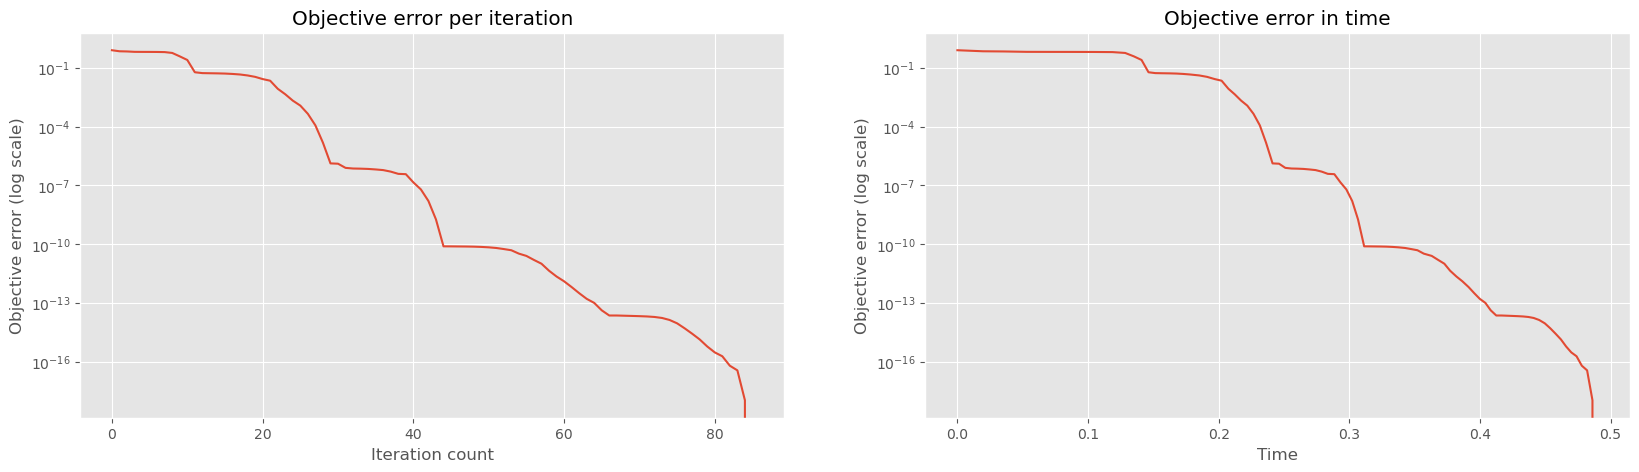

In [25]:
# Visualise evolution of objective values
plt.figure(figsize = (20,5))

plt.subplot(1, 2, 1)
plt.plot(every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log');    
plt.title('Objective error per iteration')
plt.xlabel('Iteration count');    plt.ylabel('Objective error (log scale)')
plt.subplot(1, 2, 2)
plt.plot(every_iter['time'],every_iter['obj'] - min(every_iter['obj']))
plt.yscale('log')
plt.title('Objective error in time')
plt.xlabel('Time');    plt.ylabel('Objective error (log scale)')

#plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.show()

In [26]:
#df_every = pd.DataFrame.from_dict(every_iter)
df_every = pd.concat([
                pd.DataFrame.from_dict( {a:b for a,b in every_iter.items() if a not in ['norms'] } ),
                pd.DataFrame.from_dict( {'norms-'+a:b for a,b in every_iter['norms'].items()} )], axis = 1)
display(df_every.tail())
#
df_every.to_pickle('Outputs/Exact – RPQN - Every.pkl') # To read back use pd.read_pickle(file_name)

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
81,81,0.0,0.473889,0.03,0.6,6.138540e-07,-2.540210e-08,3.196280e-07,4.344318e-07,6.138540e-07,2.540210e-08
82,82,0.0,0.477923,0.03,0.6,-1.775658e-07,-1.830840e-08,9.793711e-08,1.262236e-07,1.775658e-07,1.830840e-08
83,83,0.0,0.481969,0.03,0.6,1.062040e-06,-1.364596e-08,5.378429e-07,7.510375e-07,1.062040e-06,1.364596e-08
84,84,0.0,0.486069,0.03,0.6,7.293435e-07,-1.132480e-08,3.703342e-07,5.157859e-07,7.293435e-07,1.132480e-08
85,85,0.0,0.490233,0.03,0.6,3.743731e-07,-8.415212e-09,1.913942e-07,2.647886e-07,3.743731e-07,8.415212e-09


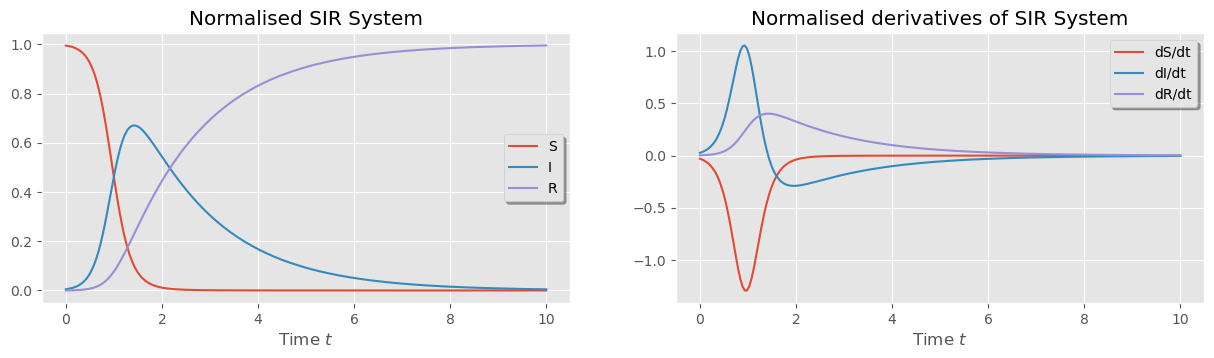

In [27]:
# Plot SIR curves
plt.figure(figsize=(15,3.5))
plt.subplot(1, 2, 1)
plt.plot(Tₑ, ρ.T/n)
plt.xlabel(r'Time $t$')
plt.legend(['S', 'I', 'R'], shadow=True)
plt.title('Normalised SIR System')

plt.subplot(1, 2, 2)
plt.plot(Tₑ, asarray(SIR(0.0, ρ, ᾱ[0], ᾱ[1])).T/n)
plt.xlabel(r'Time $t$')
plt.legend(['dS/dt', 'dI/dt', 'dR/dt'], shadow=True)
plt.title('Normalised derivatives of SIR System')
plt.show()

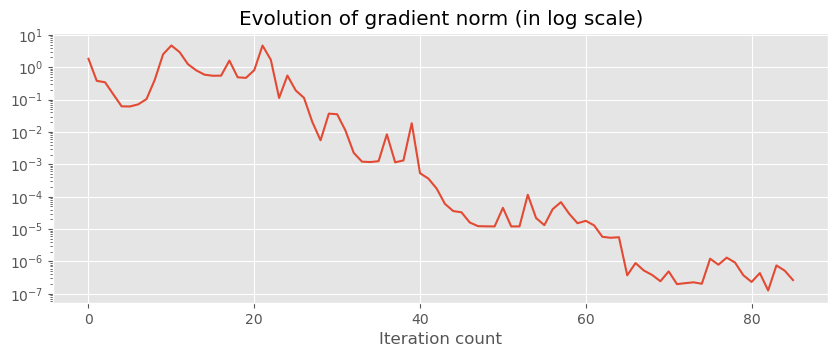

In [28]:
# Evolution of gradient norm
plt.figure(figsize=(10,3.5))
plt.plot(df_every['norms-ℓ_2'].to_numpy())
#plt.plot(df_every['norms-ℓ_1'].to_numpy())
#plt.plot(df_every['norms-max'].to_numpy())
plt.yscale('log')
#plt.xscale('log')
plt.title('Evolution of gradient norm (in log scale)')
plt.xlabel('Iteration count')
plt.show()

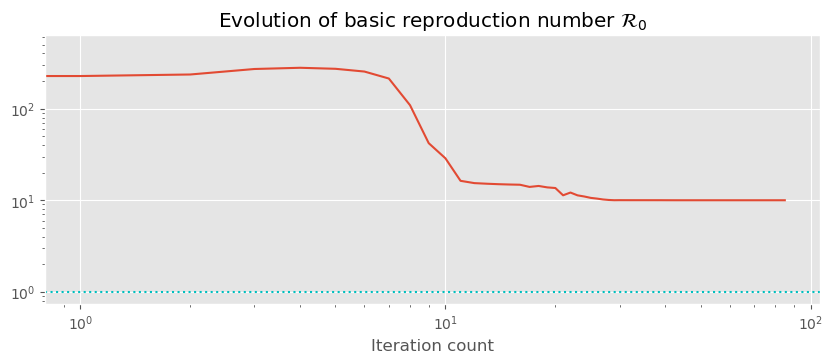

In [29]:
# Evolution of basic reproduction number
plt.figure(figsize=(10,3.5))
plt.plot(df_every['β'].to_numpy() * n / df_every['γ'].to_numpy())
plt.axhline(y=1, c='c', linestyle=':')
plt.yscale('log')
plt.xscale('log')
plt.title('Evolution of basic reproduction number $\mathcal{R}_0$')
plt.xlabel('Iteration count')
plt.show()

In [30]:
α̂ = df_every['β'][ argmin(df_every['obj']) ], df_every['γ'][ argmin(df_every['obj']) ]

β_its, γ_its = df_every['β'].to_numpy(), df_every['γ'].to_numpy()

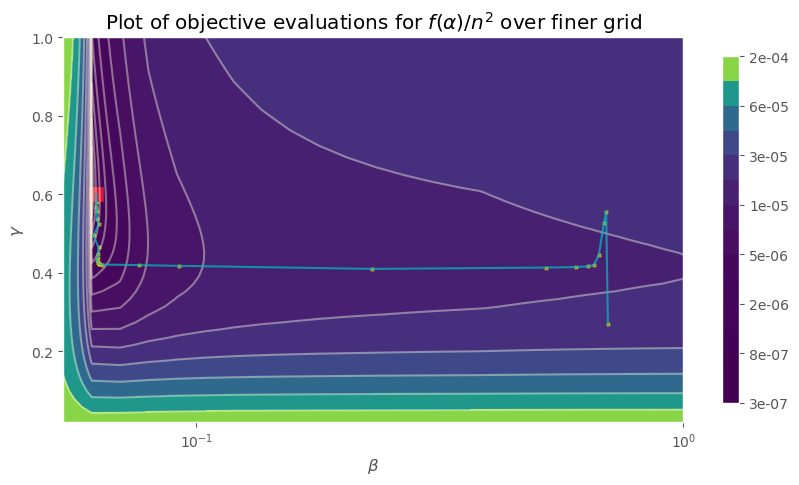

In [31]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
plt.xscale('symlog', linthresh = 3e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

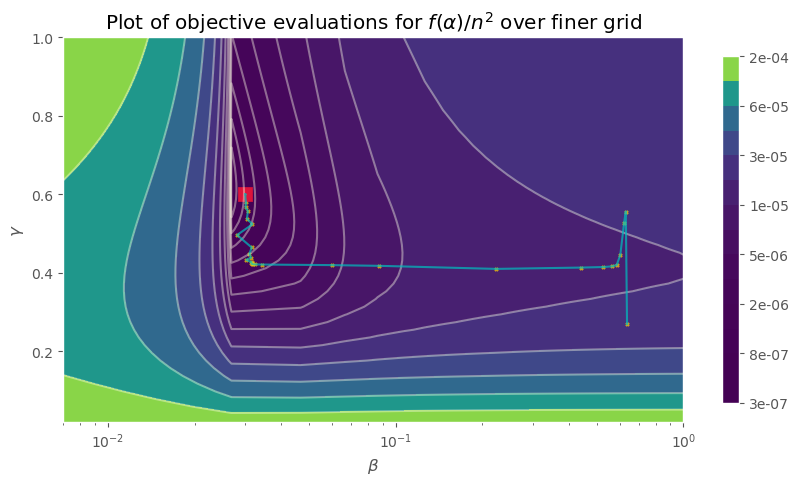

In [32]:
# Contour plot
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')

plt.plot( β_its, γ_its, c='c', alpha=0.7, marker='')                          # Optimisation path
plt.scatter( β_its, γ_its, s=5, c='#FFD300', marker='x', alpha=0.7 )
plt.scatter( α̂[0], α̂[1], s=100, marker='s', color='crimson' )                 # Display min

ax.set_xlabel(r'$\beta$');    ax.set_ylabel(r'$\gamma$')
plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
plt.xscale('log')
#plt.xscale('symlog', linthresh = 1e-1)
plt.show()
#fig.savefig('contour_coarse.pdf', bbox_inches='tight', pad_inches=0)

---

# Joint plots

In [31]:
RPQN_every  = pd.read_pickle('Outputs/Exact – RPQN - Every.pkl')
nmAPG_every = pd.read_pickle('Outputs/Exact – nmAPG - Every.pkl')
FISTA_every = pd.read_pickle('Outputs/Exact – FISTA - Every.pkl')
PGD_every   = pd.read_pickle('Outputs/Exact – PGD - Every.pkl')

In [32]:
PGD_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
1694,1693,9.338234e-07,26.744332,0.029996,0.600977,0.002715,0.001922,0.002318,0.002352,0.002715,0.001922
1695,1694,9.312506e-07,26.756315,0.029995,0.600976,0.000897,0.001910,0.001404,0.001492,0.001910,0.000897
1696,1695,9.293673e-07,26.766338,0.029994,0.600975,0.000008,0.001902,0.000955,0.001345,0.001902,0.000008
1697,1696,1.183139e-07,26.787221,0.029990,0.599975,-0.023122,-0.000181,0.011652,0.016350,0.023122,0.000181
1698,1697,6.292543e-10,26.809558,0.030000,0.599975,-0.000371,-0.000051,0.000211,0.000265,0.000371,0.000051


In [33]:
FISTA_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
358,357,0.000006,2.638405,0.029986,0.602517,-0.000027,0.004887,0.002457,0.003456,0.004887,0.000027
359,358,0.000006,2.644122,0.029986,0.602524,-0.000027,0.004900,0.002463,0.003465,0.004900,0.000027
360,359,0.000006,2.649841,0.029986,0.602529,-0.000026,0.004909,0.002468,0.003471,0.004909,0.000026
361,360,0.000006,2.655561,0.029986,0.602531,-0.000026,0.004913,0.002470,0.003474,0.004913,0.000026
362,361,0.000006,2.661289,0.029986,0.602531,-0.000027,0.004913,0.002470,0.003474,0.004913,0.000027


In [34]:
nmAPG_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
290,290,4.980783542507488e-09,4.580678,0.030001,0.599929,0.000606,-0.000137,0.000371,0.000439,0.000606,0.000137
291,291,4.927240900547394e-09,4.608134,0.030000,0.599929,0.000120,-0.000142,0.000131,0.000131,0.000142,0.000120
292,292,5.0008056312502024e-09,4.631730,0.030000,0.599929,-0.000771,-0.000142,0.000457,0.000554,0.000771,0.000142
293,293,4.870036107332972e-09,4.660706,0.030000,0.599930,-0.000299,-0.000135,0.000217,0.000232,0.000299,0.000135
294,294,4.8857724090973656e-09,4.687041,0.030001,0.599930,0.000148,-0.000135,0.000142,0.000142,0.000148,0.000135


In [35]:
RPQN_every.tail()

,it,obj,time,β,γ,df_β,df_γ,norms-ℓ_1,norms-ℓ_2,norms-max,norms-min
81,81,0.0,0.473889,0.03,0.6,6.138540e-07,-2.540210e-08,3.196280e-07,4.344318e-07,6.138540e-07,2.540210e-08
82,82,0.0,0.477923,0.03,0.6,-1.775658e-07,-1.830840e-08,9.793711e-08,1.262236e-07,1.775658e-07,1.830840e-08
83,83,0.0,0.481969,0.03,0.6,1.062040e-06,-1.364596e-08,5.378429e-07,7.510375e-07,1.062040e-06,1.364596e-08
84,84,0.0,0.486069,0.03,0.6,7.293435e-07,-1.132480e-08,3.703342e-07,5.157859e-07,7.293435e-07,1.132480e-08
85,85,0.0,0.490233,0.03,0.6,3.743731e-07,-8.415212e-09,1.913942e-07,2.647886e-07,3.743731e-07,8.415212e-09


In [36]:
from matplotlib   import colormaps
CMap = colormaps['YlGnBu']
colours_RPQN = CMap(linspace(0.3,1,14))

CMap = colormaps['YlOrBr']
colours_GD = CMap(linspace(0.3,1,14))

CMap = colormaps['RdPu']
colours_FISTA = CMap(linspace(0.3,1,14))

CMap = colormaps['BuGn']
colours_nmAPG = CMap(linspace(0.3,1,14))

In [37]:
# Best value RPQN
α̂_LM = RPQN_every['β'][ argmin(RPQN_every['obj']) ], RPQN_every['γ'][ argmin(RPQN_every['obj']) ]
β_LM, γ_LM = maximum(RPQN_every['β'].to_numpy(), 0.0071), RPQN_every['γ'].to_numpy()

# Best value FISTA
α̂_FISTA = FISTA_every['β'][ argmin(FISTA_every['obj']) ], FISTA_every['γ'][ argmin(FISTA_every['obj']) ]
β_FISTA, γ_FISTA = maximum(FISTA_every['β'].to_numpy(), 0.0071), FISTA_every['γ'].to_numpy()

# Best value nmAPG
α̂_nmAPG = nmAPG_every['β'][ argmin(nmAPG_every['obj']) ], nmAPG_every['γ'][ argmin(nmAPG_every['obj']) ]
β_nmAPG, γ_nmAPG = maximum(nmAPG_every['β'].to_numpy(), 0.0071), nmAPG_every['γ'].to_numpy()

# Best value PGD
α̂_PGD = PGD_every['β'][ argmin(PGD_every['obj']) ], PGD_every['γ'][ argmin(PGD_every['obj']) ]
β_PGD, γ_PGD = maximum(PGD_every['β'].to_numpy(), 0.0071), PGD_every['γ'].to_numpy()

In [38]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.007,1,nβ)
γ_axis = linspace(0.02,1,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

Plot of objective evaluations for f(α)/n² over finer grid


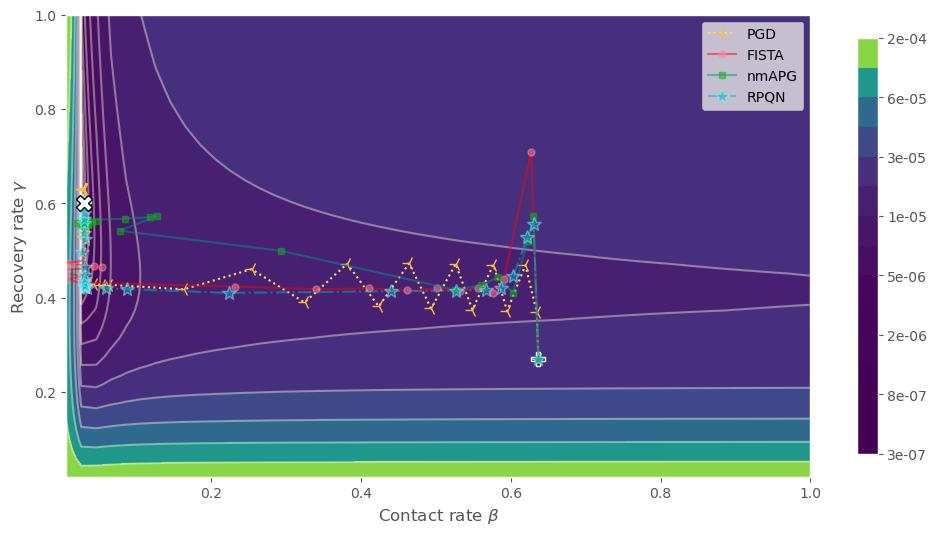

In [39]:
# Contour plot
print('Plot of objective evaluations for f(α)/n² over finer grid')

X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
ℓ = np.logspace( np.log( Misfit.min()/n**2 ), np.log( Misfit.max()/n**2 ), num=15, endpoint=True, base=np.e)

#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
#fig, ax = plt.subplots(ncols=1, figsize=(12*0.55, 6*0.7))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
fig.colorbar(cp, shrink=0.9, format='%.0e')



# Starting point
plt.plot( β_LM[0], γ_LM[0], markersize=10, marker='P', color='white', markerfacecolor='b' )

# Optimisation path PGD
ℓ_PGD = 1660
plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = colours_GD[2],
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')

plt.plot( β_PGD[ ℓ_PGD:], γ_PGD[ ℓ_PGD:], c='gold', alpha=0.01, marker='3', linestyle = ':', markersize='4')

# Optimisation path FISTA
ℓ_FISTA = 20
plt.plot( β_FISTA[:ℓ_FISTA], γ_FISTA[:ℓ_FISTA], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='10', label='FISTA')
plt.plot( β_FISTA[ ℓ_FISTA-1:], γ_FISTA[ ℓ_FISTA-1:], c='r', markeredgecolor = 'xkcd:rosa',
         alpha=0.5, marker='.',linestyle = '-',markersize='1')


# Optimisation path nmAPG
ℓ_nmAPG = 30
plt.plot( β_nmAPG[:ℓ_nmAPG], γ_nmAPG[:ℓ_nmAPG], c='xkcd:teal', 
         markeredgecolor = 'xkcd:green', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='s', linestyle = '-', markersize='5', label='nmAPG')
plt.plot( β_nmAPG[ ℓ_nmAPG-1:], γ_nmAPG[ ℓ_nmAPG-1:], c='xkcd:teal', markeredgecolor = 'xkcd:green',
         alpha=0.5, marker='s',linestyle = '-',markersize='1')


# Optimisation path LM
plt.plot( β_LM, γ_LM, c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", #markerfacecolor = '#FFD300', 
         alpha=0.5, marker='*', linestyle = '-.', markersize=10, label='RPQN')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=12, marker='X', markeredgecolor='black', color='white' )



ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('log')
#plt.xscale('symlog', linthresh = 3e-1)
plt.legend()
#plt.xticks( plt.xticks()[0][0::2] )
#plt.yticks( plt.yticks()[0][0::2] )
plt.show()
fig.savefig('Outputs/Exact – Contour[a] -dev.pdf', bbox_inches='tight', pad_inches=0)

Compute finer mesh around optimal point:

In [40]:
# Finer evaluations
nβ, nγ = 51, 51
Misfit, Reprod = zeros([2, nβ, nγ])
β_axis = linspace(0.028,0.032,nβ)
γ_axis = linspace(0.5,0.7,nγ)
for (i,β) in enumerate(β_axis):
    for (j,γ) in enumerate(γ_axis):
        Misfit[i,j] = obj_eval_a([β,γ]).item()
        Reprod[i,j] = n * β / (γ + m)
i_0 = unravel_index(argmin(Misfit),  Misfit.shape)                     # finer mesh
M_0, β_0, γ_0 = Misfit[i_0],    β_axis[i_0[0]],    γ_axis[i_0[1]]

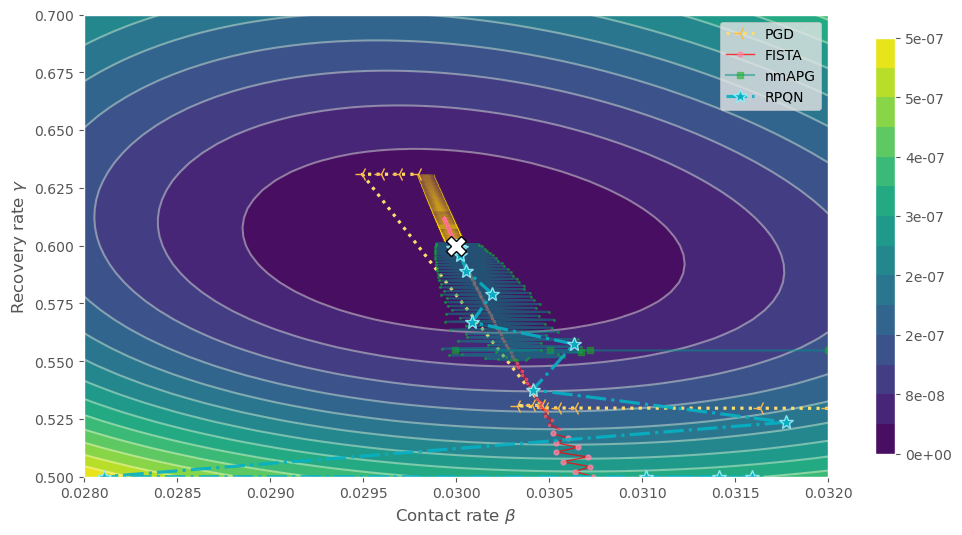

In [41]:
# Contour plot objective functional
X_c, Y_c = meshgrid(β_axis, γ_axis, indexing='ij')
ℓ = linspace((Misfit/n**2).min(),(Misfit/n**2).max(),15)
'''ℓ = np.logspace( np.log( Misfit[Misfit>0.0].min()/n**2 ), np.log( Misfit.max()/n**2 ), 
                num=15, endpoint=True, base=np.e)
'''
#fig, ax = plt.subplots(ncols=1, figsize=(50, 20))
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
#fig, ax = plt.subplots(ncols=1, figsize=(12*0.55, 6*0.7))
cp = ax.contourf(X_c, Y_c, Misfit/n**2, ℓ)
ax.contour(cp, colors='#FFFFE6', alpha= 0.4)                                  # Contour plot
#plt.scatter(β_0, γ_0, s=20, c='#FFFFE6', marker='s')          # Display min
#plt.scatter(ᾱ[0], ᾱ[1], s=20, c='#FFFFE6', marker='x')          # Display min



# Optimisation path PGD
ℓ_PGD = 21
h_PGD = 33
'''plt.plot( β_PGD[:-ℓ_PGD], γ_PGD[:-ℓ_PGD], c='xkcd:pale gold', markeredgecolor = 'gold',
         alpha=1, marker='3', linestyle = ':', markersize='10', label='PDG')'''
plt.plot( clip(β_PGD[ ℓ_PGD:h_PGD],0.02,0.032), clip(γ_PGD[ ℓ_PGD:h_PGD],0.5, 0.7), 
            c='xkcd:pale gold', markeredgecolor = colours_GD[2], #'gold', 
             linewidth=2.3,
                 alpha=1, marker='3', linestyle = ':', markersize='10', label='PGD')
plt.plot( β_PGD[ h_PGD-1:], γ_PGD[ h_PGD-1:], c='gold', alpha=0.7, marker='3', linestyle = '-', 
         markersize=0.1, linewidth=0.05)


# Optimisation path FISTA
ℓ_FISTA = 30
h_FISTA = 40
plt.plot( β_FISTA[ℓ_FISTA:h_FISTA], γ_FISTA[ℓ_FISTA:h_FISTA], c='r', 
             markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa', linewidth=1,
                 alpha=0.75, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( β_FISTA[ h_FISTA:], γ_FISTA[ h_FISTA:], c='r', markeredgecolor = 'xkcd:rosa', linewidth=2,
             alpha=0.5, marker='.',linestyle = '-',markersize='3')

# Optimisation path nmAPG
h_nmAPG = 20
ℓ_nmAPG = 25
plt.plot( clip(β_nmAPG[h_nmAPG:ℓ_nmAPG],0.02,0.032), γ_nmAPG[h_nmAPG:ℓ_nmAPG], c='xkcd:teal', 
         markeredgecolor = 'xkcd:green', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='s', linestyle = '-', markersize='5', label='nmAPG')
plt.plot( β_nmAPG[ ℓ_nmAPG-1:], γ_nmAPG[ ℓ_nmAPG-1:], c='xkcd:teal', markeredgecolor = 'xkcd:green',
         alpha=0.5, marker='s',linestyle = '-',markersize='1')


# Optimisation path LM
ℓ_LM = 18
plt.plot( clip(β_LM[ℓ_LM:],0.02,0.032), clip(γ_LM[ℓ_LM:],0.5, 0.7), c='xkcd:turquoise blue', 
             markeredgecolor = "xkcd:robin's egg blue", #markerfacecolor = '#FFD300', 
             linewidth=2.3, alpha=0.9, marker='*', linestyle = '-.', markersize=10, label='RPQN')


# Best estimated minimiser
plt.plot( α̂_LM[0], α̂_LM[1], markersize=15, marker='X', markeredgecolor='black', color='white' )





fig.colorbar(cp, shrink=0.9, format='%.0e')
ax.set_xlabel(r'Contact rate $\beta$');    ax.set_ylabel(r'Recovery rate $\gamma$')
#plt.title(r'Plot of objective evaluations for ${f(\alpha)}/{n^2}$ over finer grid')
#plt.xscale('symlog')
plt.legend()
#plt.xticks( plt.xticks()[0][0::2] )
#plt.yticks( plt.yticks()[0][0::2] )
plt.show()
fig.savefig('Outputs/Exact – Contour[b] -dev.pdf', bbox_inches='tight', pad_inches=0)

In [42]:
# Minimal objective achieved:
Lowest = min(min(PGD_every['obj']), min(FISTA_every['obj']), min(nmAPG_every['obj']), min(RPQN_every['obj']))

Objective values per iteration


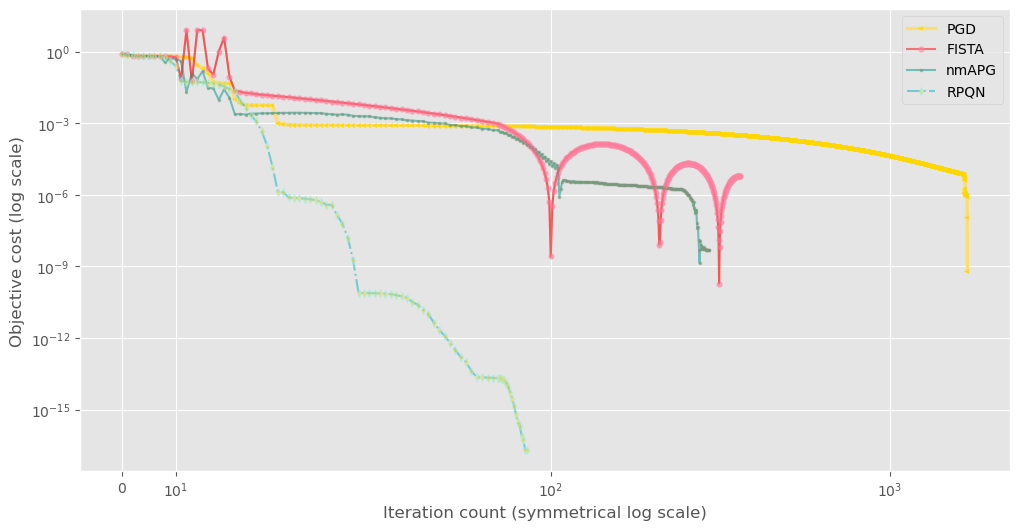

In [43]:
# Visualise evolution of objective values
plt.figure(figsize = (12,6))

plt.plot(PGD_every['obj'], c='xkcd:pale gold', markeredgecolor = 'gold', linewidth=2.3,
                 alpha=1, marker='3', linestyle = '-', markersize='4', label='PGD')
plt.plot(FISTA_every['obj'], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='.', linestyle = '-', markersize='7', label='FISTA')
plt.plot( nmAPG_every['obj'], c='xkcd:teal', 
         markeredgecolor = 'xkcd:gray', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='s', linestyle = '-', markersize='2', label='nmAPG')
plt.plot(FISTA_every['obj'], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.25, marker='.', linestyle = '-', markersize='5')
plt.plot( RPQN_every['obj'], c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', 
         alpha=0.5, marker='d', linestyle = '-.', markersize=4, label='RPQN')

plt.yscale('log');    
plt.xscale('log');
#plt.title('Objective values per iteration')
print('Objective values per iteration')
plt.xlabel('Iteration count (symmetrical log scale)');    plt.ylabel('Objective cost (log scale)')
plt.xscale('symlog', linthresh = 7e1)

plt.legend()
##plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.savefig('Outputs/Exact – Objective -dev.pdf', bbox_inches='tight', pad_inches=0,transparent=False)
plt.show()

Objective values per iteration


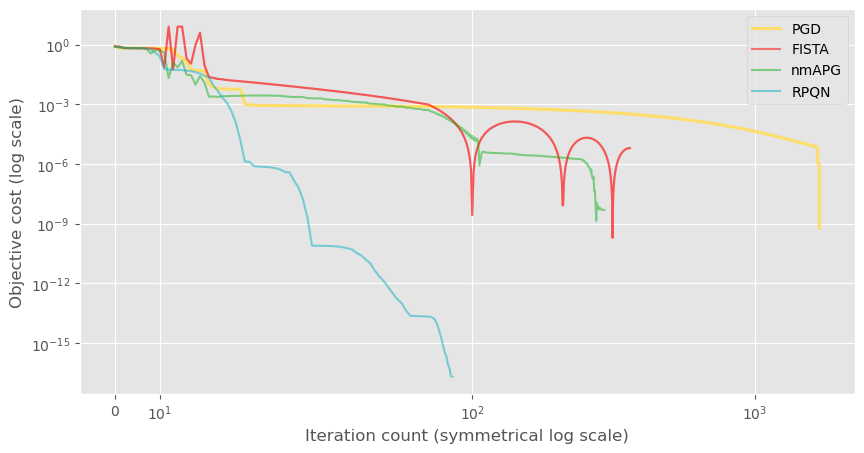

In [62]:
# Visualise evolution of objective values
plt.figure(figsize = (10,5))

plt.plot(PGD_every['obj'], c='xkcd:pale gold', markeredgecolor = 'gold', linewidth=2.3,
                 alpha=1, marker='', linestyle = '-', markersize='4', label='PGD')
plt.plot(FISTA_every['obj'], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.5, marker='', linestyle = '-', markersize='7', label='FISTA')
plt.plot( nmAPG_every['obj'], c='xkcd:green', 
         markeredgecolor = 'xkcd:green', markerfacecolor = 'xkcd:green',
         alpha=0.5, marker='', linestyle = '-', markersize=2, label='nmAPG')
plt.plot(FISTA_every['obj'], c='r', 
         markeredgecolor = 'xkcd:rosa', markerfacecolor = 'xkcd:rosa',
         alpha=0.25, marker='', linestyle = '-', markersize='5')
plt.plot( RPQN_every['obj'], c='xkcd:turquoise blue', 
         markeredgecolor = "xkcd:robin's egg blue", markerfacecolor = '#FFD300', 
         alpha=0.5, marker='', linestyle = '-', markersize=4, label='RPQN')

plt.yscale('log');    
plt.xscale('log');
#plt.title('Objective values per iteration')
print('Objective values per iteration')
plt.xlabel('Iteration count (symmetrical log scale)');    plt.ylabel('Objective cost (log scale)')
plt.xscale('symlog', linthresh = 7e1)

plt.legend()
##plt.savefig(out_folder+'Objective.pdf', bbox_inches='tight',transparent=True)
plt.savefig('Outputs/Exact – Objective -dev.pdf', bbox_inches='tight', pad_inches=0,transparent=False)
plt.show()

Difference in norm of the best minimisers found:

In [44]:
norm(asarray(α̂_LM) - α̂_FISTA), norm(asarray(α̂_LM) - α̂_PGD), norm(asarray(α̂_PGD) - α̂_FISTA)

(1.4027862537652518e-05, 2.4719450163216214e-05, 1.0692277219898467e-05)

In [45]:
norm(asarray(α̂_LM) - asarray([0.03,0.6])), norm(asarray([0.03,0.6]) - α̂_PGD), norm(asarray([0.03,0.6]) - α̂_FISTA)

(4.485022218762663e-09, 2.4723935178705386e-05, 1.40323475084634e-05)

---